In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sps
import random as rnd

from scipy.sparse import *

from matplotlib import pyplot

In [2]:
urm_path = '../content/data_train.csv'
urm_all_df = pd.read_csv(filepath_or_buffer=urm_path,
                                sep=",",
                                header=0,
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

urm_all_df.columns = ["UserID", "ItemID", "Interaction"]

In [3]:
urm_all_df.head(10)

,UserID,ItemID,Interaction
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0
5,1,187,1.0
6,1,205,1.0
7,1,222,1.0
8,1,237,1.0
9,1,354,1.0


In [4]:
print ("The number of interactions is {}".format(len(urm_all_df)))

The number of interactions is 478730


In [5]:
userID_unique = urm_all_df["UserID"].unique()
itemID_unique = urm_all_df["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(urm_all_df)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 22222, Number of users	 12638
Max ID items	 22347, Max Id users	 13024

Average interactions per user 37.88
Average interactions per item 21.54

Sparsity 99.83 %


# Remove empty profiles

In [6]:
# Remove empty IDs
mapped_id, original_id = pd.factorize(urm_all_df["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(urm_all_df["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)



# Let's create the mapping from items indices to original item_ids
item_index_to_original_ID = pd.Series(item_original_ID_to_index.index,index = item_original_ID_to_index.values)



original_item_ID = 125
print("New index for item {} is {}".format(original_item_ID, item_original_ID_to_index[original_item_ID]))


urm_all_df["UserID"] = urm_all_df["UserID"].map(user_original_ID_to_index)
urm_all_df["ItemID"] = urm_all_df["ItemID"].map(item_original_ID_to_index)
urm_all_df.head(n=10)

New index for item 125 is 93


,UserID,ItemID,Interaction
0,0,0,1.0
1,0,1,1.0
2,0,2,1.0
3,0,3,1.0
4,0,4,1.0
5,0,5,1.0
6,0,6,1.0
7,0,7,1.0
8,0,8,1.0
9,0,9,1.0


In [7]:
userID_unique = urm_all_df["UserID"].unique()
itemID_unique = urm_all_df["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(urm_all_df)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 22222, Number of users	 12638
Max ID items	 22221, Max Id users	 12637

Average interactions per user 37.88
Average interactions per item 21.54

Sparsity 99.83 %


In [8]:
urm_all = sps.coo_matrix((urm_all_df["Interaction"].values,
                          (urm_all_df["UserID"].values, urm_all_df["ItemID"].values)))

urm_all

<12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in COOrdinate format>

In [ ]:
urm_all = urm_all.tocsr()
urm_all

<13025x22348 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [ ]:
train_test_split = 0.80

n_interactions = urm_all.nnz

train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])

urm_train = sps.csr_matrix((urm_all.data[train_mask],
                            (urm_all.row[train_mask], urm_all.col[train_mask])))

val_mask = np.logical_not(train_mask)

urm_val = sps.csr_matrix((urm_all.data[val_mask],
                            (urm_all.row[val_mask], urm_all.col[val_mask])))

# Evaluate the trained model


For the BaseRecommenderClass i needed to slightly change the evalutation function

In [9]:
def precision(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)

    return precision_score

def recall(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]

    return recall_score

def AP(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

def evaluate_SLIMelasticnet(URM_test, recommender_object, at=10):

    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0

    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]

        if len(relevant_items)>0:

            recommended_items = recommender_object.recommend(user_id, cutoff=at,remove_seen_flag=True)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)

    mean_precision = cumulative_precision / num_eval
    mean_recall = cumulative_recall / num_eval
    MAP = cumulative_AP / num_eval

    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP))
    return MAP, mean_precision, mean_recall

# SLIM ElasticNet

In [ ]:
!unzip /content/Recommenders.zip

In [ ]:
!unzip /content/Utils.zip

In [12]:
from Recommenders.Recommender_utils import check_matrix
from sklearn.linear_model import ElasticNet
from Recommenders.BaseSimilarityMatrixRecommender import BaseItemSimilarityMatrixRecommender
from Recommenders.Similarity.Compute_Similarity_Python import Incremental_Similarity_Builder
from Utils.seconds_to_biggest_unit import seconds_to_biggest_unit
from tqdm import tqdm
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import sys
import time


class SLIMElasticNetRecommender(BaseItemSimilarityMatrixRecommender):
    """
    Train a Sparse Linear Methods (SLIM) item similarity model.
    NOTE: ElasticNet solver is parallel, a single intance of SLIM_ElasticNet will
          make use of half the cores available

    See:
        Efficient Top-N Recommendation by Linear Regression,
        M. Levy and K. Jack, LSRS workshop at RecSys 2013.

        SLIM: Sparse linear methods for top-n recommender systems,
        X. Ning and G. Karypis, ICDM 2011.
        http://glaros.dtc.umn.edu/gkhome/fetch/papers/SLIM2011icdm.pdf
    """

    RECOMMENDER_NAME = "SLIMElasticNetRecommender"

    def __init__(self, URM_train, verbose = True):
        super(SLIMElasticNetRecommender, self).__init__(URM_train, verbose = verbose)

    @ignore_warnings(category=ConvergenceWarning)
    def fit(self, l1_ratio=0.1, alpha = 1.0, positive_only=True, topK = 100):

        assert l1_ratio>= 0 and l1_ratio<=1, "{}: l1_ratio must be between 0 and 1, provided value was {}".format(self.RECOMMENDER_NAME, l1_ratio)
        self.l1_ratio = l1_ratio
        self.positive_only = positive_only
        self.topK = topK


        # initialize the ElasticNet model
        self.model = ElasticNet(alpha=alpha,
                                l1_ratio=self.l1_ratio,
                                positive=self.positive_only,
                                fit_intercept=False,
                                copy_X=False,
                                precompute=True,
                                selection='random',
                                max_iter=100,
                                tol=1e-4)

        URM_train = check_matrix(self.URM_train, 'csc', dtype=np.float32)

        n_items = URM_train.shape[1]

        similarity_builder = Incremental_Similarity_Builder(self.n_items, initial_data_block=self.n_items*self.topK, dtype = np.float32)

        start_time = time.time()
        start_time_printBatch = start_time

        # fit each item's factors sequentially (not in parallel)
        for currentItem in range(n_items):

            # get the target column
            y = URM_train[:, currentItem].toarray()

            # set the j-th column of X to zero
            start_pos = URM_train.indptr[currentItem]
            end_pos = URM_train.indptr[currentItem + 1]

            current_item_data_backup = URM_train.data[start_pos: end_pos].copy()
            URM_train.data[start_pos: end_pos] = 0.0

            # fit one ElasticNet model per column
            self.model.fit(URM_train, y)

            # self.model.coef_ contains the coefficient of the ElasticNet model
            # let's keep only the non-zero values
            nonzero_model_coef_index = self.model.sparse_coef_.indices
            nonzero_model_coef_value = self.model.sparse_coef_.data

            # Check if there are more data points than topK, if so, extract the set of K best values
            if len(nonzero_model_coef_value) > self.topK:
                # Partition the data because this operation does not require to fully sort the data
                relevant_items_partition = np.argpartition(-np.abs(nonzero_model_coef_value), self.topK-1, axis=0)[0:self.topK]
                nonzero_model_coef_index = nonzero_model_coef_index[relevant_items_partition]
                nonzero_model_coef_value = nonzero_model_coef_value[relevant_items_partition]

            similarity_builder.add_data_lists(row_list_to_add=nonzero_model_coef_index,
                                              col_list_to_add=np.ones(len(nonzero_model_coef_index), dtype = int) * currentItem,
                                              data_list_to_add=nonzero_model_coef_value)


            # finally, replace the original values of the j-th column
            URM_train.data[start_pos:end_pos] = current_item_data_backup

            elapsed_time = time.time() - start_time
            new_time_value, new_time_unit = seconds_to_biggest_unit(elapsed_time)


            if time.time() - start_time_printBatch > 300 or currentItem == n_items-1:
                self._print("Processed {} ({:4.1f}%) in {:.2f} {}. Items per second: {:.2f}".format(
                    currentItem+1,
                    100.0* float(currentItem+1)/n_items,
                    new_time_value,
                    new_time_unit,
                    float(currentItem)/elapsed_time))

                sys.stdout.flush()
                sys.stderr.flush()

                start_time_printBatch = time.time()

        self.W_sparse = similarity_builder.get_SparseMatrix()

In [ ]:
slim_elastic_recommender = SLIMElasticNetRecommender(urm_train)
slim_elastic_recommender.fit(alpha = 0.0015746723778813712, l1_ratio = 0.005,topK = 100)

SLIMElasticNetRecommender: URM Detected 198 ( 1.6%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 117 ( 0.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 8129 (36.6%) in 5.00 min. Items per second: 27.09
SLIMElasticNetRecommender: Processed 16534 (74.4%) in 10.00 min. Items per second: 27.55
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 13.57 min. Items per second: 27.30


In [ ]:
usr_id = 3
slim_elastic_recommender.recommend(usr_id,cutoff = 10)

[589, 227, 46, 50, 678, 3708, 109, 1478, 818, 812]

In [ ]:
map, mp,mr = evaluate_SLIMelasticnet(urm_val,slim_elastic_recommender)
print(f"MAP@10 on val is {map}")

Recommender results are: Precision = 978.7000, Recall = 1362.0845, MAP = 0.0822
MAP@10 on val is 0.08221288820563075


# K-fold Cross-Validatoin


Define the k data partitions for k-folds cross-validation

In [13]:
from sklearn.model_selection import KFold

n_interactions = urm_all.nnz
num_folds = 5

kf = KFold(n_splits=num_folds,  shuffle = True)
data_folds = []
indices = np.arange(n_interactions)
for train_inc, val_inc in kf.split(indices):
  train_mask = np.full(n_interactions,True)
  train_mask[val_inc] = False
  val_mask = np.logical_not(train_mask)

  fold_urm_train = sps.csr_matrix((urm_all.data[train_mask],
                            (urm_all.row[train_mask], urm_all.col[train_mask])))
  fold_urm_val = sps.csr_matrix((urm_all.data[val_mask],
                            (urm_all.row[val_mask], urm_all.col[val_mask])))
  data_folds.append({"train":fold_urm_train,"val":fold_urm_val})


**Implement the iterative random hyperparameter search with k-fold cross-validation**

In [ ]:
from scipy.stats import loguniform

In [ ]:
rnd_alpha = np.array(list(set(loguniform.rvs(0.0001, 2, size=10).astype(float))))
rnd_l1_ratio = np.array(list(set(loguniform.rvs(0.0001, 0.5, size=10).astype(float))))
rnd_topK = np.array(list(set(loguniform.rvs(10, 100, size=10).astype(int))))
print(f"Alpha:{rnd_alpha}")
print(f"L1 ratio:{rnd_l1_ratio}")
print(f"TopK:{rnd_topK}")

Alpha:[1.30994807e-02 5.86626070e-04 7.30473779e-02 1.31791508e-01
 7.69363583e-02 3.93965437e-01 2.20254899e-04 2.36300271e-01
 1.87432862e-02 1.36074517e-04]
L1 ratio:[2.14233986e-01 4.90963364e-01 1.71406710e-01 2.44504035e-02
 1.70160179e-02 8.59273819e-04 1.82340799e-04 1.66530298e-02
 1.76382878e-02 7.41293096e-04]
TopK:[65 11 76 13 47 51 54 22 29 31]


In [ ]:
# At some point I decided to change the topK distribution
rnd_topK = np.array(list(set(loguniform.rvs(10, 250, size=7).astype(int))))
rnd_topK

array([104, 136,  12, 206,  78,  49,  30])

In [14]:
# Here I manually insert the hyperparameters values obtained randomly from the previous runtime sessions
rnd_alpha = np.array([1.30994807e-02, 5.86626070e-04, 7.30473779e-02, 1.31791508e-01,
 7.69363583e-02, 3.93965437e-01, 2.20254899e-04, 2.36300271e-01,
 1.87432862e-02, 1.36074517e-04])
rnd_l1_ratio = np.array([2.14233986e-01, 4.90963364e-01, 1.71406710e-01, 2.44504035e-02,
 1.70160179e-02, 8.59273819e-04, 1.82340799e-04, 1.66530298e-02,
 1.76382878e-02, 7.41293096e-04])
rnd_topK = np.array([104, 136,  12, 206,  78,  49,  30])
print(f"Alpha:{rnd_alpha}")
print(f"L1 ratio:{rnd_l1_ratio}")
print(f"TopK:{rnd_topK}")

Alpha:[1.30994807e-02 5.86626070e-04 7.30473779e-02 1.31791508e-01
 7.69363583e-02 3.93965437e-01 2.20254899e-04 2.36300271e-01
 1.87432862e-02 1.36074517e-04]
L1 ratio:[2.14233986e-01 4.90963364e-01 1.71406710e-01 2.44504035e-02
 1.70160179e-02 8.59273819e-04 1.82340799e-04 1.66530298e-02
 1.76382878e-02 7.41293096e-04]
TopK:[104 136  12 206  78  49  30]


Alpha

In [ ]:
# Here i manually insert the 10-fold CV MAP that I obtianed during the previous runtime sessions

hyperparameter_search_rnd = pd.DataFrame(columns = ["alpha", "MAP"])
hyperparameter_search_rnd["alpha"] = rnd_alpha
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="alpha")

hyperparameter_search_rnd.at[9,'MAP'] = 0.05117893530078858
hyperparameter_search_rnd.at[6,'MAP'] = 0.0576803740326813

In [ ]:
hyperparameter_search_rnd

,alpha,MAP
9,0.000136,0.051179
6,0.000220,0.05768
1,0.000587,NaN
0,0.013099,NaN
8,0.018743,NaN
2,0.073047,NaN
4,0.076936,NaN
3,0.131792,NaN
7,0.236300,NaN
5,0.393965,NaN


In [ ]:
hyperparameter_search_rnd.index[2:]

Int64Index([1, 0, 8, 2, 4, 3, 7, 5], dtype='int64')

In [ ]:
# Continue to evaluate the alpha paremeters with CV from the alpha value thrird  in the grid

default_l1_ratio = 0.005
default_topK = 100

for index in hyperparameter_search_rnd.index[2:]:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')
      recommender = SLIMElasticNetRecommender(fold['train'])
      recommender.fit(topK = default_topK,l1_ratio=default_l1_ratio, alpha=hyperparameter_search_rnd.loc[index,"alpha"])

      map, mp,mr = evaluate_SLIMelasticnet(fold['val'],recommender)
      folds_map.append(map)

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"alpha"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
SLIMElasticNetRecommender: URM Detected 197 ( 1.6%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 131 ( 0.6%) items with no interactions.
SLIMElasticNetRecommender: Processed 7552 (34.0%) in 5.00 min. Items per second: 25.17
SLIMElasticNetRecommender: Processed 15537 (69.9%) in 10.00 min. Items per second: 25.89
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 14.31 min. Items per second: 25.88
Recommender results are: Precision = 908.9000, Recall = 1209.6563, MAP = 0.0770
Fold 1 evaluations started
SLIMElasticNetRecommender: URM Detected 230 ( 1.8%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 133 ( 0.6%) items with no interactions.
SLIMElasticNetRecommender: Processed 8154 (36.7%) in 5.00 min. Items per second: 27.17
SLIMElasticNetRecommender: Processed 16582 (74.6%) in 10.00 min. Items per second: 27.63
SLIMElasticNetRecommender: Processed 22221 (100.0%) in 13.53 min. Items per second: 27.37
Recommender re

In [ ]:
# default_l1_ratio = 0.005
# default_topK = 100

# for index in hyperparameter_search_rnd.index:
#     folds_map = []
#     for k,fold in enumerate(data_folds):
#       print(f'Fold {k} evaluations started')
#       recommender = SLIMElasticNetRecommender(fold['train'])
#       recommender.fit(topK = default_topK,l1_ratio=default_l1_ratio, alpha=hyperparameter_search_rnd.loc[index,"alpha"])

#       map, mp,mr = evaluate_SLIMelasticnet(fold['val'],recommender)
#       folds_map.append(map)

#     cv_map = np.array(folds_map).sum()/len(data_folds)
#     print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"alpha"]} is {cv_map}')
#     hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
SLIMElasticNetRecommender: URM Detected 96 ( 0.8%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 44 ( 0.2%) items with no interactions.
SLIMElasticNetRecommender: Processed 5886 (26.5%) in 5.00 min. Items per second: 19.61
SLIMElasticNetRecommender: Processed 12360 (55.6%) in 10.00 min. Items per second: 20.60
SLIMElasticNetRecommender: Processed 19108 (86.0%) in 15.00 min. Items per second: 21.23
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 17.32 min. Items per second: 21.39
Recommender results are: Precision = 388.7000, Recall = 830.4174, MAP = 0.0520
Fold 1 evaluations started
SLIMElasticNetRecommender: URM Detected 102 ( 0.8%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 46 ( 0.2%) items with no interactions.
SLIMElasticNetRecommender: Processed 6009 (27.0%) in 5.00 min. Items per second: 20.02
SLIMElasticNetRecommender: Processed 12360 (55.6%) in 10.00 min. Items per second: 20.60
SLIMElasticNetRecom

      alpha       MAP
9  0.000136  0.051179
6  0.000220   0.05768
1  0.000587  0.075324
0  0.013099  0.080226
8  0.018743  0.077917
2  0.073047  0.067169
4  0.076936   0.06677
3  0.131792  0.061745
7  0.236300  0.055341
5  0.393965   0.04891


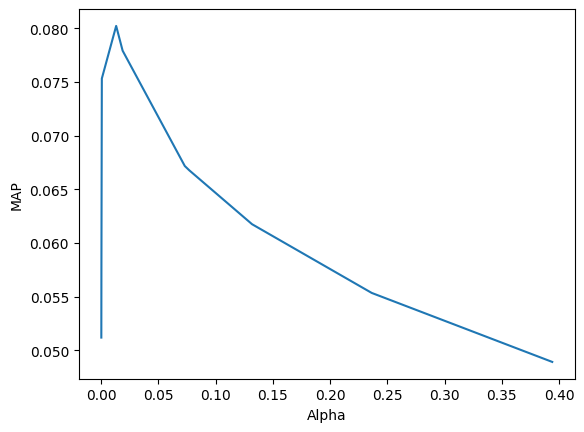

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["alpha"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('Alpha')
pyplot.show()

L1 ratio


In [ ]:
best_alpha_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_alpha_value

alpha    0.013099
MAP      0.080226
Name: 0, dtype: object

In [ ]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["alpha", "l1_ratio", "MAP"])
hyperparameter_search_rnd["l1_ratio"] = rnd_l1_ratio
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="l1_ratio")
hyperparameter_search_rnd["alpha"] = best_alpha_value["alpha"]


for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')
      recommender = SLIMElasticNetRecommender(fold['train'])
      recommender.fit(l1_ratio=hyperparameter_search_rnd.loc[index,"l1_ratio"], alpha=best_alpha_value["alpha"],topK = default_topK)

      map, mp,mr = evaluate_SLIMelasticnet(fold['val'],recommender)
      folds_map.append(map)

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"l1_ratio"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
SLIMElasticNetRecommender: URM Detected 197 ( 1.6%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 131 ( 0.6%) items with no interactions.
SLIMElasticNetRecommender: Processed 8556 (38.5%) in 5.00 min. Items per second: 28.51
SLIMElasticNetRecommender: Processed 17161 (77.2%) in 10.00 min. Items per second: 28.60
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 13.00 min. Items per second: 28.50
Recommender results are: Precision = 972.9000, Recall = 1453.3506, MAP = 0.0822
Fold 1 evaluations started
SLIMElasticNetRecommender: URM Detected 230 ( 1.8%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 133 ( 0.6%) items with no interactions.
SLIMElasticNetRecommender: Processed 8769 (39.5%) in 5.00 min. Items per second: 29.23
SLIMElasticNetRecommender: Processed 17950 (80.8%) in 10.00 min. Items per second: 29.91
SLIMElasticNetRecommender: Processed 22221 (100.0%) in 12.65 min. Items per second: 29.27
Recommender re

      alpha  l1_ratio       MAP
6  0.013099  0.000182  0.080538
9  0.013099  0.000741  0.080497
5  0.013099  0.000859  0.080471
7  0.013099  0.016653  0.077756
4  0.013099  0.017016  0.077677
8  0.013099  0.017638  0.077554
3  0.013099  0.024450   0.07627
2  0.013099  0.171407  0.059269
0  0.013099  0.214234  0.056418
1  0.013099  0.490963  0.042646


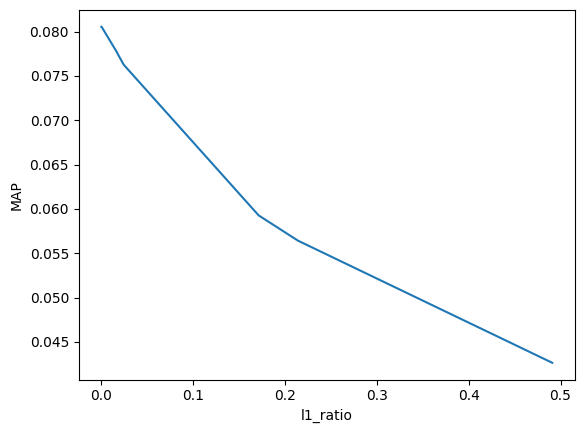

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["l1_ratio"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('l1_ratio')
pyplot.show()

In [ ]:
best_l1_ratio = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_l1_ratio

alpha       0.013099
l1_ratio    0.000182
MAP         0.080538
Name: 6, dtype: object

Number of the most similar neighbours to consider

In [ ]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["alpha", "l1_ratio","TopK", "MAP"])
hyperparameter_search_rnd["TopK"] = rnd_topK
hyperparameter_search_rnd["alpha"] = best_alpha_value["alpha"]
hyperparameter_search_rnd["l1_ratio"] = best_l1_ratio["l1_ratio"]

for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')
      recommender = SLIMElasticNetRecommender(fold['train'])
      recommender.fit(l1_ratio=best_l1_ratio["l1_ratio"], topK=hyperparameter_search_rnd.loc[index,"TopK"], alpha = best_alpha_value["alpha"])

      map, mp,mr = evaluate_SLIMelasticnet(fold['val'],recommender)
      folds_map.append(map)

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"TopK"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
SLIMElasticNetRecommender: URM Detected 230 ( 1.8%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 120 ( 0.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 8981 (40.4%) in 5.00 min. Items per second: 29.93
SLIMElasticNetRecommender: Processed 18635 (83.9%) in 10.00 min. Items per second: 31.05
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 12.05 min. Items per second: 30.74
Recommender results are: Precision = 955.9000, Recall = 1435.5457, MAP = 0.0796
Fold 1 evaluations started
SLIMElasticNetRecommender: URM Detected 228 ( 1.8%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 113 ( 0.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 9254 (41.6%) in 5.00 min. Items per second: 30.84
SLIMElasticNetRecommender: Processed 18997 (85.5%) in 10.00 min. Items per second: 31.66
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 11.84 min. Items per second: 31.27
Recommender re

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["TopK"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

In [ ]:
urm_all = sps.csr_matrix((urm_all.data,
                            (urm_all.row, urm_all.col)))

In [ ]:
recommender = SLIMElasticNetRecommender(urm_all)
recommender.fit()

Similarity column 22348 (100.0%), 1552.59 column/sec. Elapsed time 14.39 sec


# Predict for the test data

In [ ]:
urm_path = '/content/data_target_users_test.csv'

urm_pred_df = pd.read_csv(filepath_or_buffer=urm_path,
                                sep=",",
                                header=0,
                                dtype={0:int},
                                engine='python')

urm_pred_df.columns = ["UserID"]
len(urm_pred_df['UserID'])

10882

In [ ]:
slim_elastic_recommender = SLIMElasticNetRecommender(urm_all)
slim_elastic_recommender.fit(alpha = 0.00984742352027931, l1_ratio = 0.001403680909889978,topK = 278)

SLIMElasticNetRecommender: Processed 6681 (30.1%) in 5.00 min. Items per second: 22.27
SLIMElasticNetRecommender: Processed 13483 (60.7%) in 10.00 min. Items per second: 22.47
SLIMElasticNetRecommender: Processed 20632 (92.8%) in 15.00 min. Items per second: 22.92
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 15.94 min. Items per second: 23.23


In [ ]:
# Save item-item Similarity matrix
from scipy.sparse import save_npz


save_npz("../content/item_item_similarity_SLIMelasticnet.npz", item_item_S)

**Do the predictions, but bear in mind that before feeding the user_id to the model you need to translate it to the model user indices space. Also, you have to translate the recommended item IDs into the original IDs space form the model item IDs space**

In [ ]:
pred_df = pd.DataFrame(columns = ['user_id','item_list'])

for userid in urm_pred_df['UserID']:
  if userid in user_original_ID_to_index.keys():
    # Map user ID to the index of model user space
    usr_idx = user_original_ID_to_index[userid]
    recomendatoins = slim_elastic_recommender.recommend(usr_idx, cutoff=10,remove_seen_flag=True)
    # Map item indices from model item space to original item ID
    recomendatoins = [item_index_to_original_ID[idx] for idx in recomendatoins]
  else:
    # If the user isn't present in the given data, recommend TopPop items
    recomendatoins = ["517 189 44 0 284 808 285 1 557 1266"]

  recomendatoins = " ".join(str(item) for item in recomendatoins)
  pred_df.loc[len(pred_df)] = [userid,recomendatoins]

In [ ]:
pred_df

,user_id,item_list
0,1,101 36 403 506 52 515 123 694 8 254
1,2,1095 47 12 50 28 11 102 196 4 1522
2,3,59 648 259 536 956 584 4252 857 414 2172
3,4,249 28 50 1 7 5 314 139 171 136
4,5,77 170 1570 95 4 131 135 116 1511 8
...,...,...
10877,13020,6450 6198 6452 6749 7395 7394 105 627 1191 155
10878,13021,133 6179 6720 6451 7027 13 6426 6749 579 265
10879,13022,1411 1668 809 1446 1674 1013 1258 163 776 1561
10880,13023,1124 706 329 1290 1107 138 32 96 208 1532


In [ ]:
pred_df.to_csv('/content/predSLIMelasticnet_Max.csv',index=False)